In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       estimate_feature_interaction_order
from clustering import make_clustering, plot_dendrogram
from tasks.adult import make_task_modified_hours_per_week_and_country as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
shap.initjs()

In [2]:
with open('shap.test.expl', 'rb') as f:
    explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = \
        pickle.load(f)

In [3]:
categorical_features = ['Workclass', 'Education-Num', 'Marital Status', 'Occupation',
                        'Relationship', 'Race', 'Sex', 'Country']

# Setup Task

In [4]:
clf_a, clf_b, X, X_display, y, feature_names = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[10:51:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:51:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [5]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=100)
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, X_display, masker=masker, algorithm='exact',
                               explanation_types=['mclass_diff'],
                               space_types=['log_odds'])
with open('shap.test.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 6514it [33:25,  3.24it/s]                            


CPU times: user 1h 29min 12s, sys: 5min 11s, total: 1h 34min 24s
Wall time: 33min 25s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [6]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((6513, 12), (0,), (0,))

# Difference Classifier SHAP Explanations

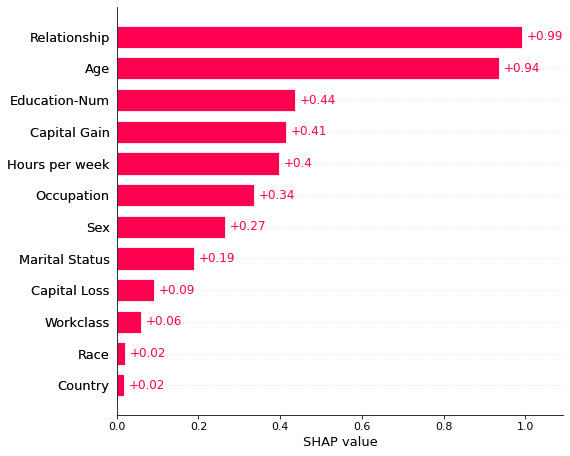

In [7]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importances)

In [8]:
global_feature_order = feature_order

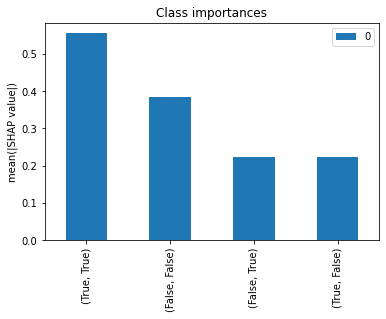

In [9]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

## Clustering of Class $(False, True)$ SHAP Values

In [10]:
%%time
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds, '(False, True)',
                          ['(False, False)', '(False, True)', '(True, True)'])

CPU times: user 37.2 s, sys: 2.36 s, total: 39.6 s
Wall time: 17.1 s


### Node RLRLRRRRRRR

In [11]:
node.class_counts, node.distance

((False, False)    5293
 (True, True)      1216
 (False, True)        3
 (True, False)        1
 dtype: int64,
 415.55082548875737)

In [12]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRLRRRRRRR,
 (False, False)    544
 (True, True)      192
 (False, True)       3
 dtype: int64,
 9.376066432483904)

Relationship == 4.0
Relationship <= 3.0 --> {'(False, False)': 3}


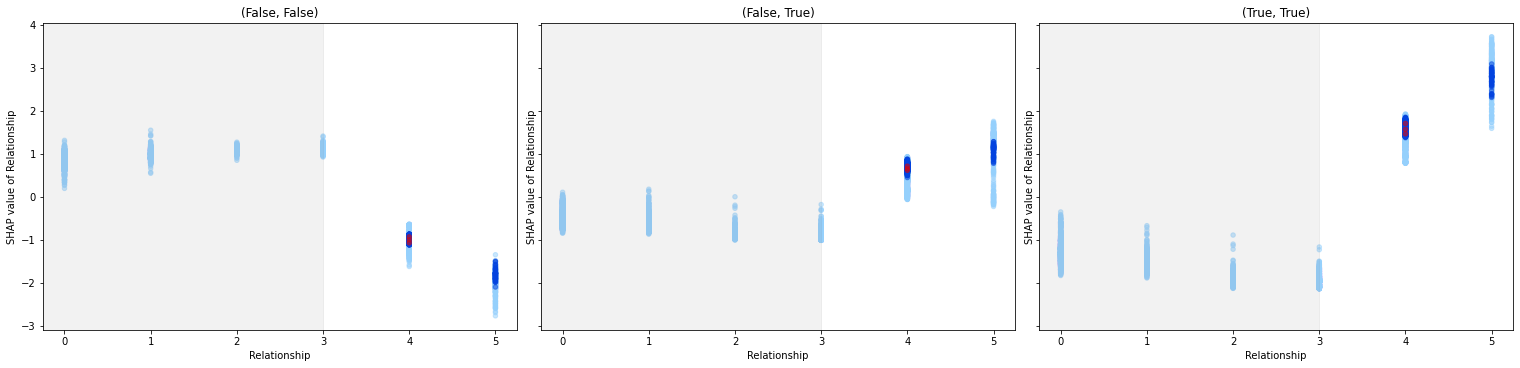

30.0 <= Age <= 56.0
Age <= 29.0 --> {'(False, False)': 3}
Age >= 62.0 --> {'(False, False)': 2, '(True, True)': 1}


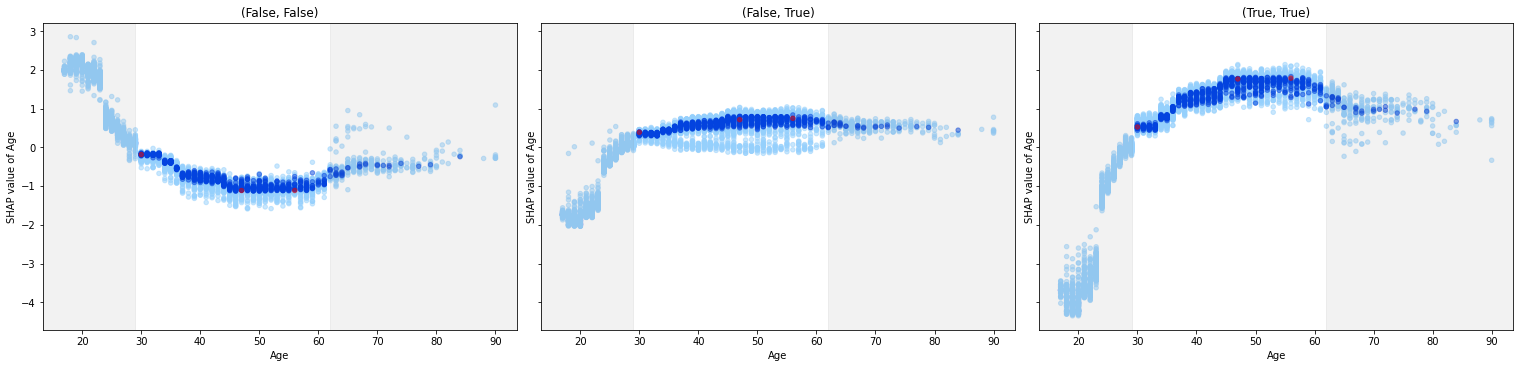

1.0 <= Occupation <= 4.0
Occupation <= 0.0 --> {'(False, False)': 3}
Occupation >= 5.0 --> {'(False, False)': 3}


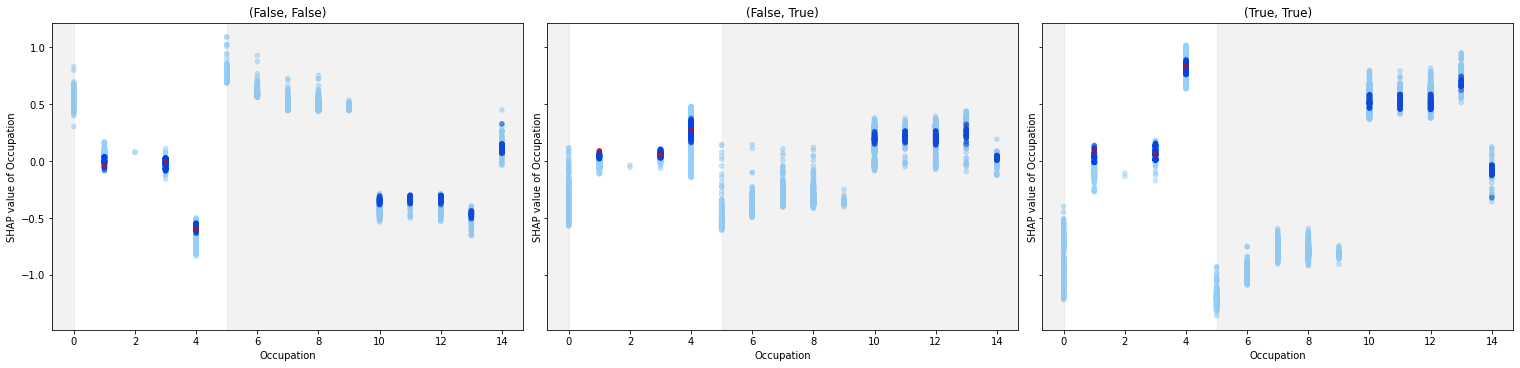

41.0 <= Hours per week <= 48.0
Hours per week <= 40.0 --> {'(False, False)': 3}
Hours per week >= 49.0 --> {'(True, True)': 3}


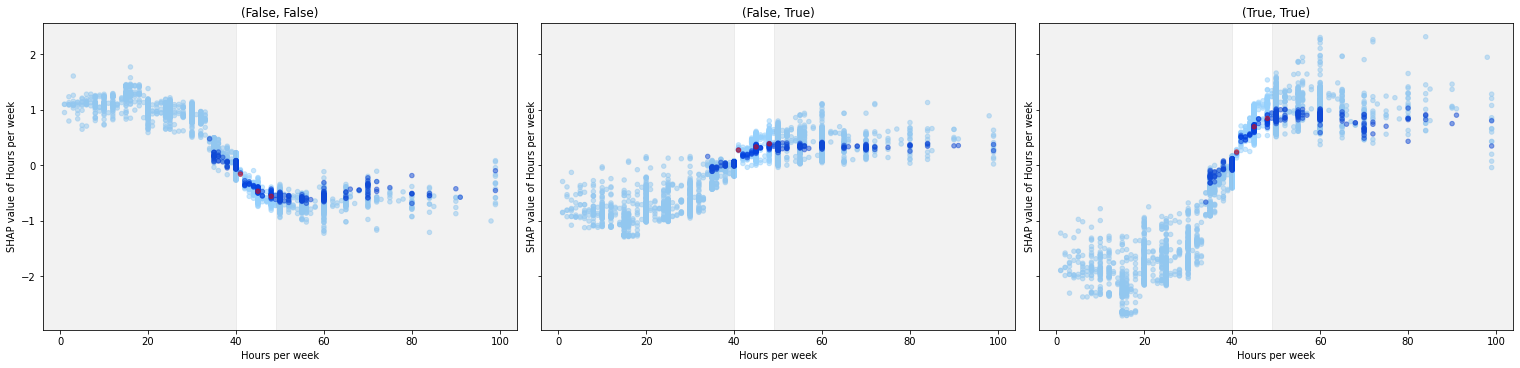

10.0 <= Education-Num <= 11.0
Education-Num <= 9.0 --> {'(False, False)': 3}
Education-Num >= 13.0 --> {'(True, True)': 3}


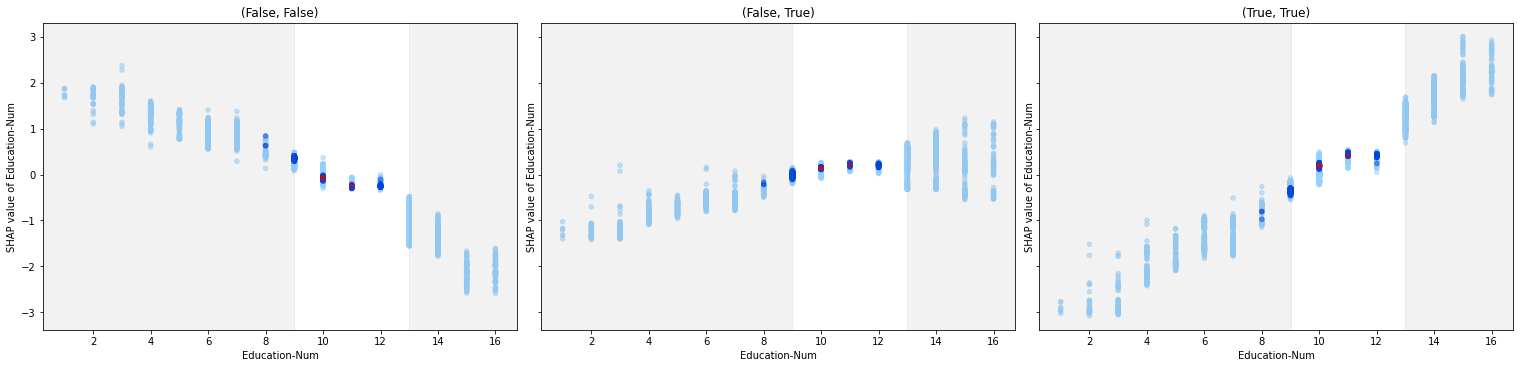

Sex == 1.0
Sex <= 0.0 --> {'(False, False)': 3}


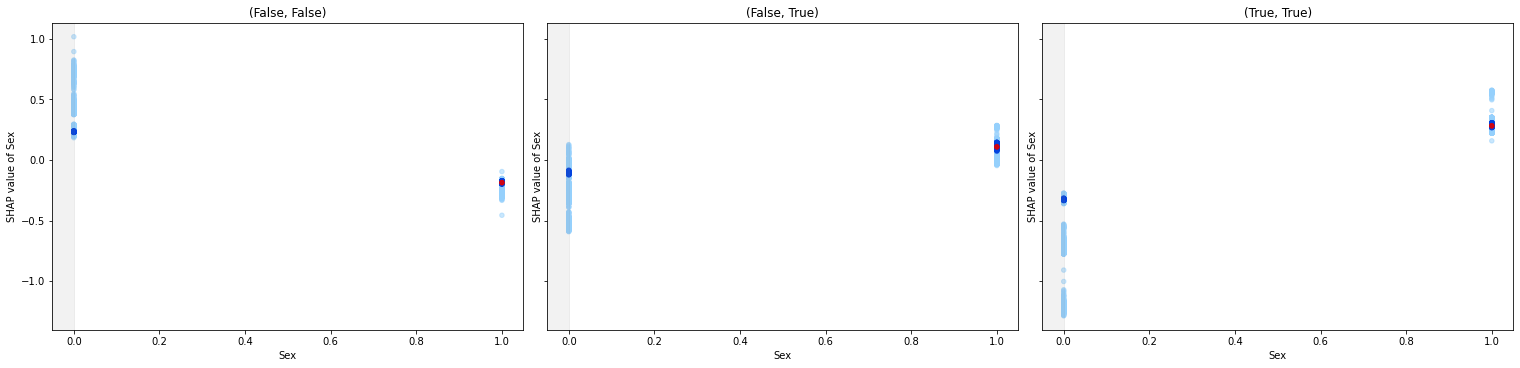

Marital Status == 2.0
Marital Status >= 4.0 --> {'(False, False)': 3}


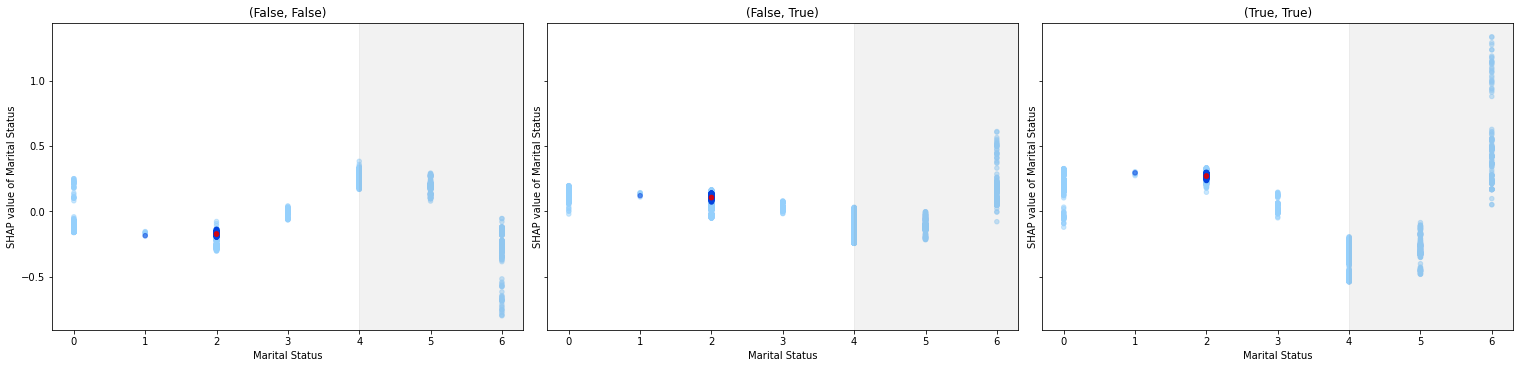

Capital Gain == 0.0
Capital Gain >= 57.0 --> {'(False, False)': 3}


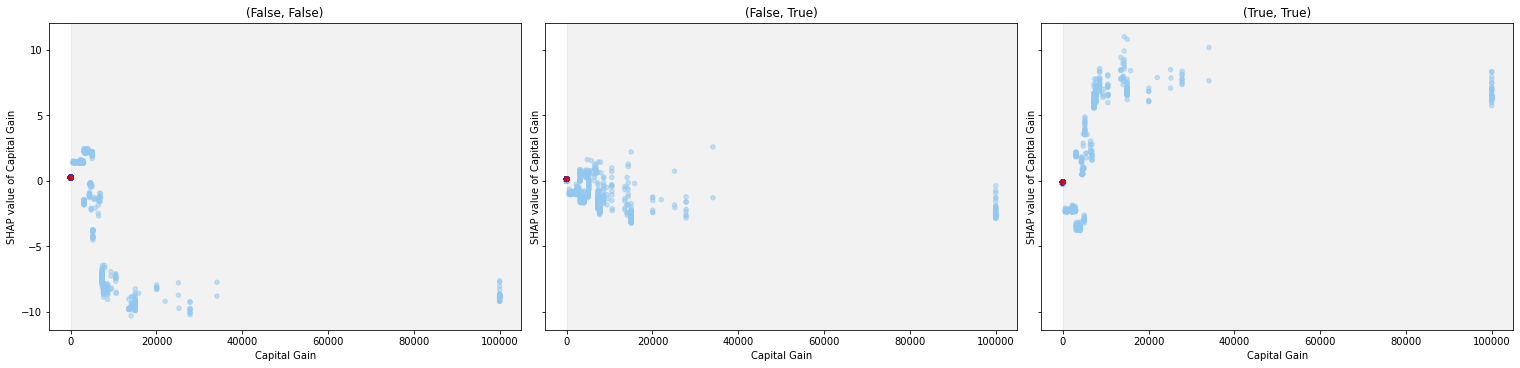

2.0 <= Workclass <= 4.0
Workclass <= 1.0 --> {'(True, True)': 3}
Workclass >= 6.0 --> {'(False, False)': 3}


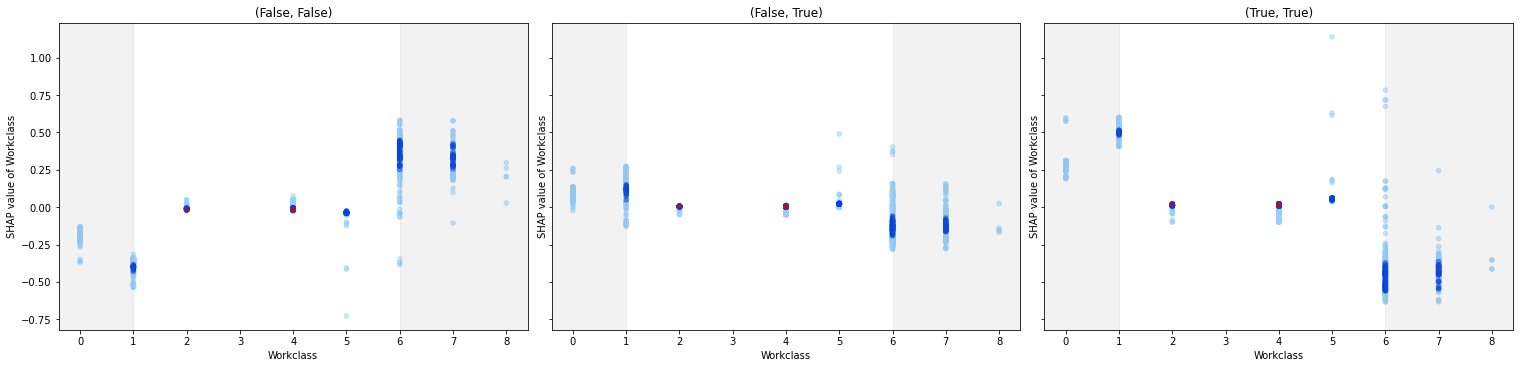

Capital Loss == 0.0
Capital Loss >= 732.0 --> {'(False, False)': 3}


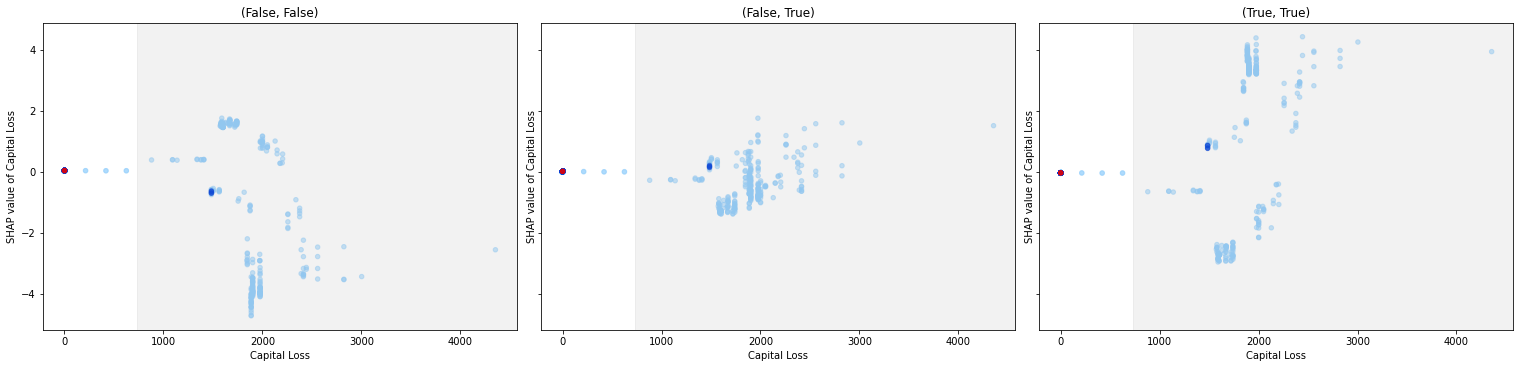

Race == 4.0
Race <= 3.0 --> {'(False, False)': 3}


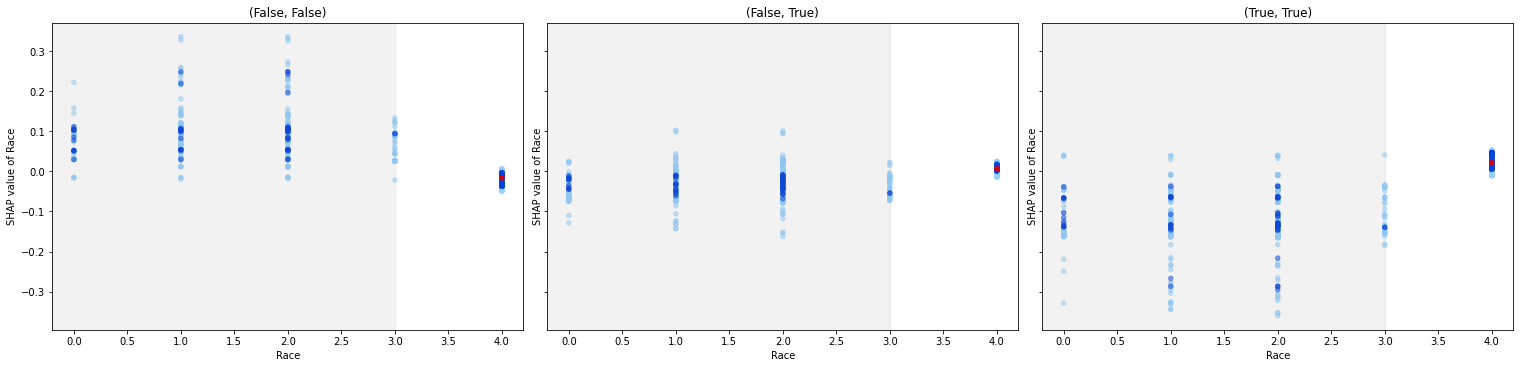

In [13]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

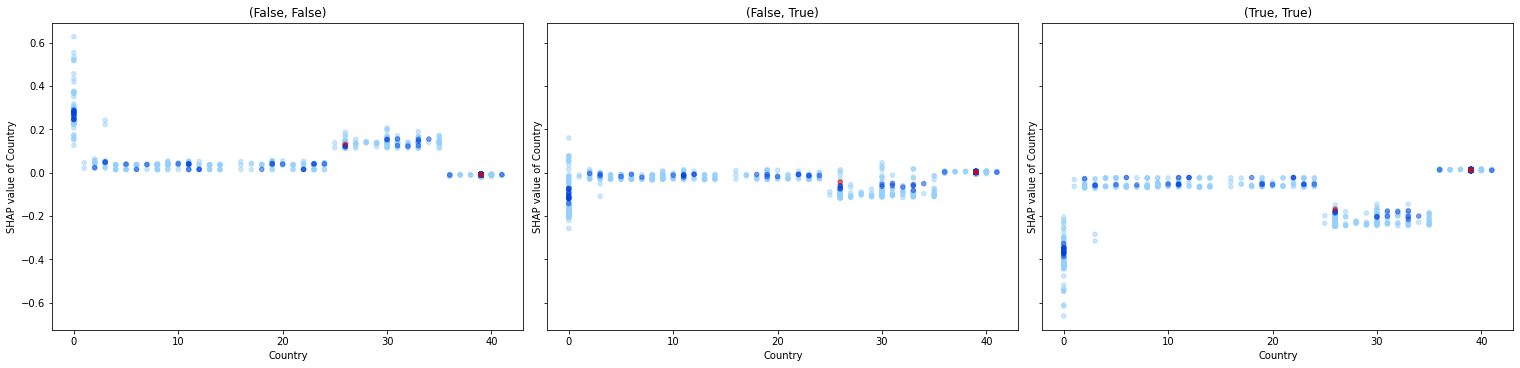

In [14]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature(feature, focus=node, alpha=0.5)

### Node RLRLRRRRRRRL

In [15]:
node = node.get_left()
node, node.class_counts, node.distance

(RLRLRRRRRRRL,
 (False, False)    167
 (True, True)      109
 (False, True)       2
 dtype: int64,
 5.1549021420056)

Relationship == 4.0
Relationship <= 3.0 --> {'(False, False)': 2}
Relationship >= 5.0 --> {'(True, True)': 2}


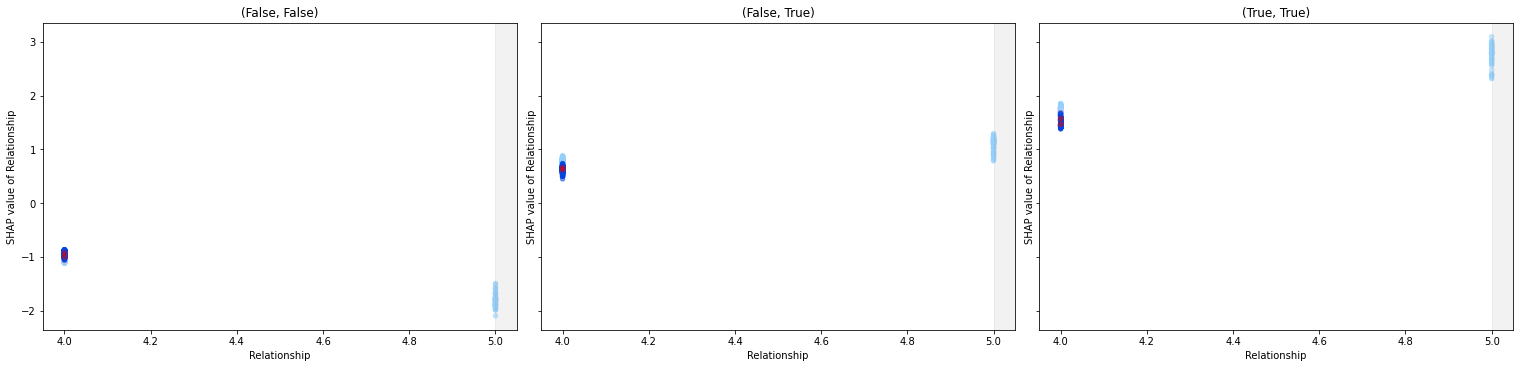

30.0 <= Age <= 47.0
Age <= 29.0 --> {'(False, False)': 2}
Age >= 62.0 --> {'(False, False)': 1, '(True, True)': 1}


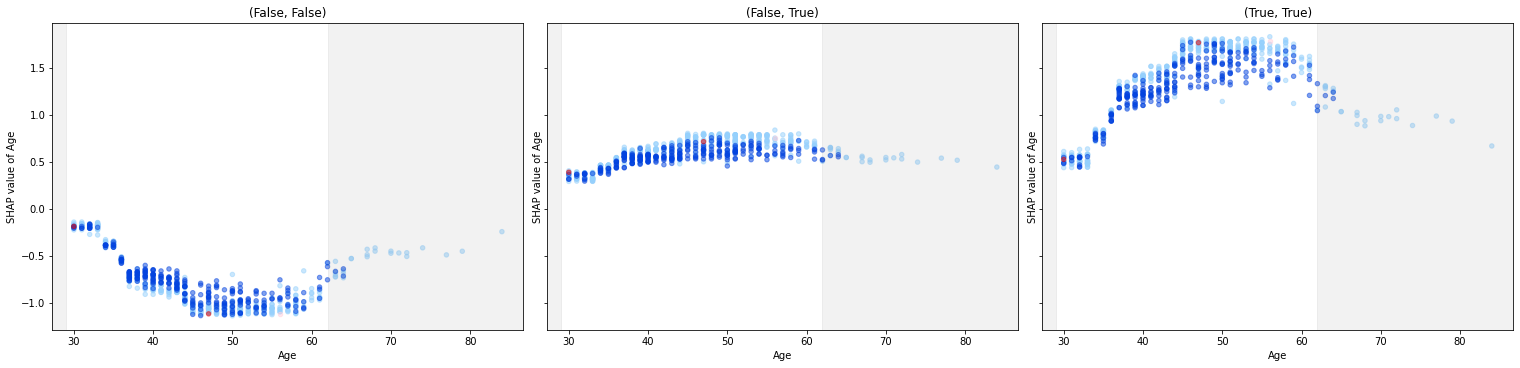

45.0 <= Hours per week <= 48.0
Hours per week <= 44.0 --> {'(False, False)': 2}
Hours per week >= 49.0 --> {'(True, True)': 2}


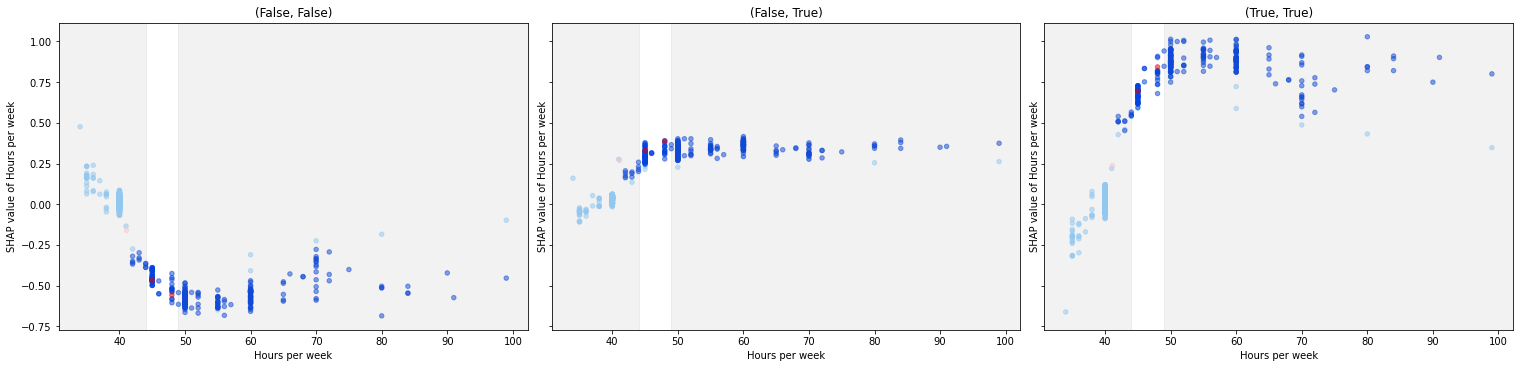

In [16]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

### Node RLRLRRRRRRRLL

In [17]:
node = node.get_left()
node, node.class_counts, node.distance

(RLRLRRRRRRRLL,
 (True, True)      77
 (False, False)    68
 (False, True)      1
 dtype: int64,
 3.0509301299066873)

Relationship == 4.0
Relationship <= 3.0 --> {'(False, False)': 1}
Relationship >= 5.0 --> {'(True, True)': 1}


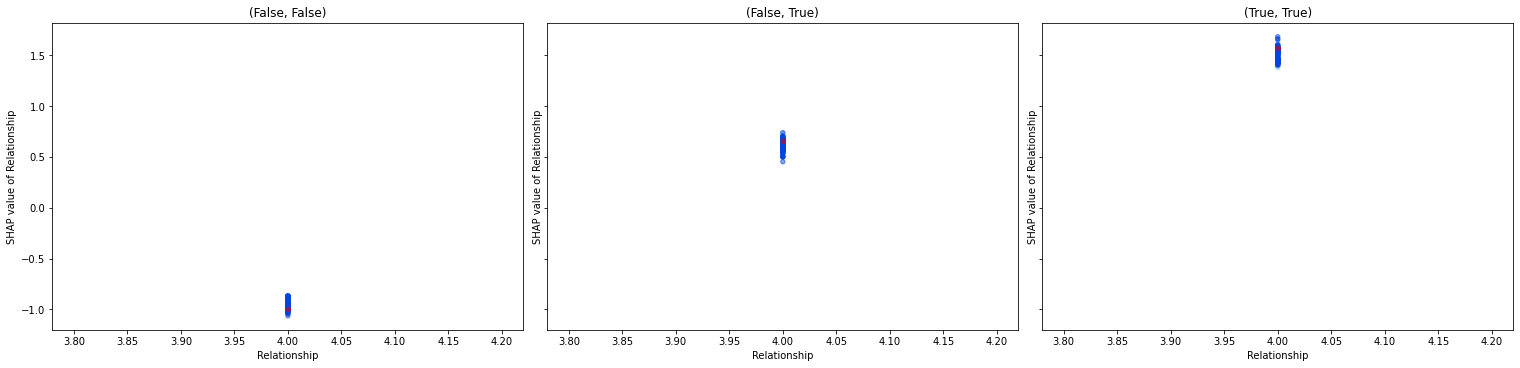

Age == 47.0
Age <= 43.0 --> {'(False, False)': 1}
Age >= 62.0 --> {'(False, False)': 1}


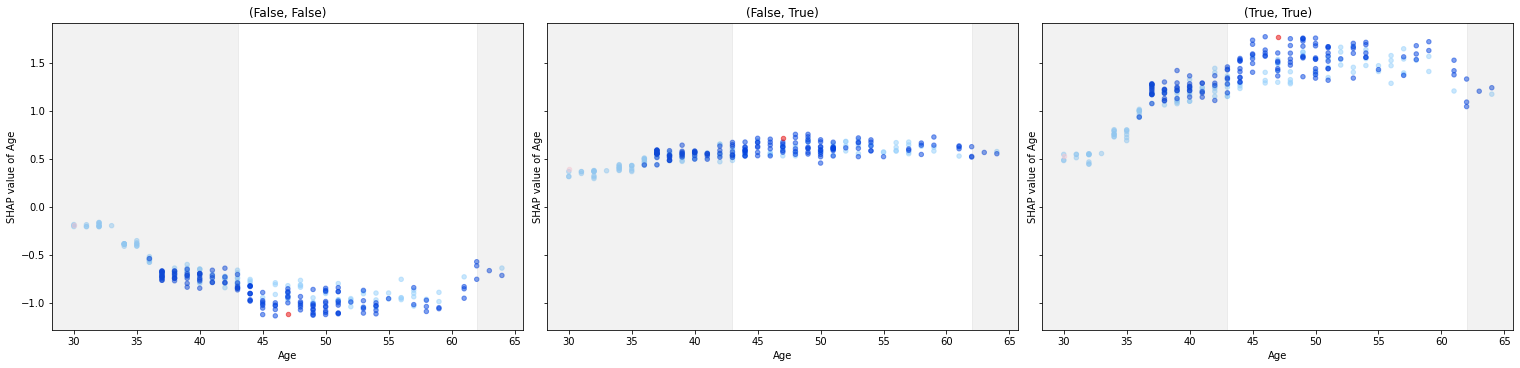

Hours per week == 45.0
Hours per week <= 44.0 --> {'(False, False)': 1}
Hours per week >= 46.0 --> {'(True, True)': 1}


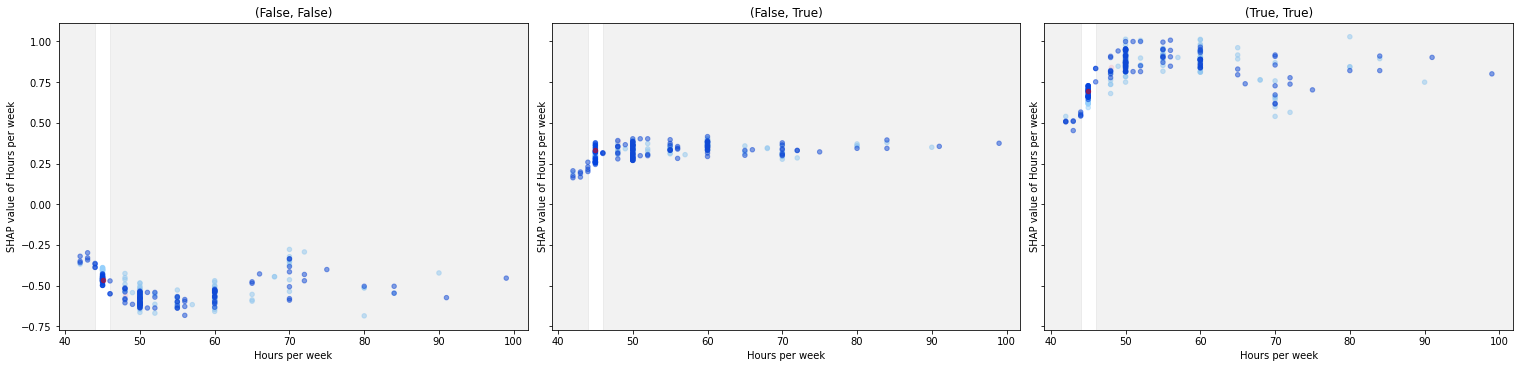

In [18]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

### Node RLRLRRRRRRRLR

In [19]:
node = node.parent.get_right()
node, node.class_counts, node.distance

(RLRLRRRRRRRLR,
 (False, False)    99
 (True, True)      32
 (False, True)      1
 dtype: int64,
 4.94401118422054)

In [20]:
node.find_cf_up('Age')

Age >= 34.0 --> {'(True, True)': 1}

In [21]:
node.class_counts[node.diff_class]

1

In [22]:
node.get_left().class_counts

(True, True)      24
(False, False)    22
(False, True)      1
dtype: int64

Relationship == 4.0
Relationship <= 3.0 --> {'(False, False)': 1}
Relationship >= 5.0 --> {'(True, True)': 1}


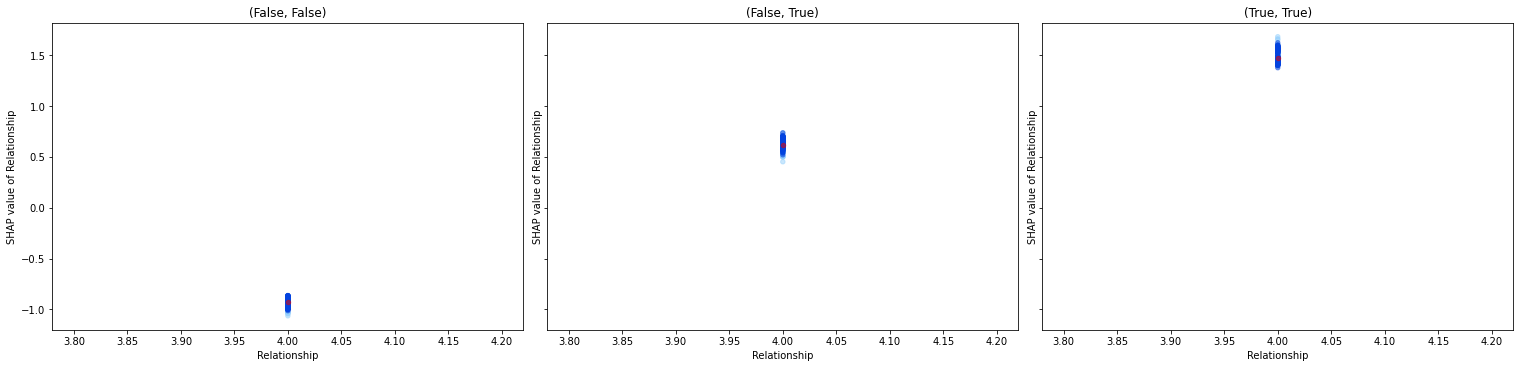

Age == 30.0
Age <= 29.0 --> {'(False, False)': 1}
Age >= 34.0 --> {'(True, True)': 1}


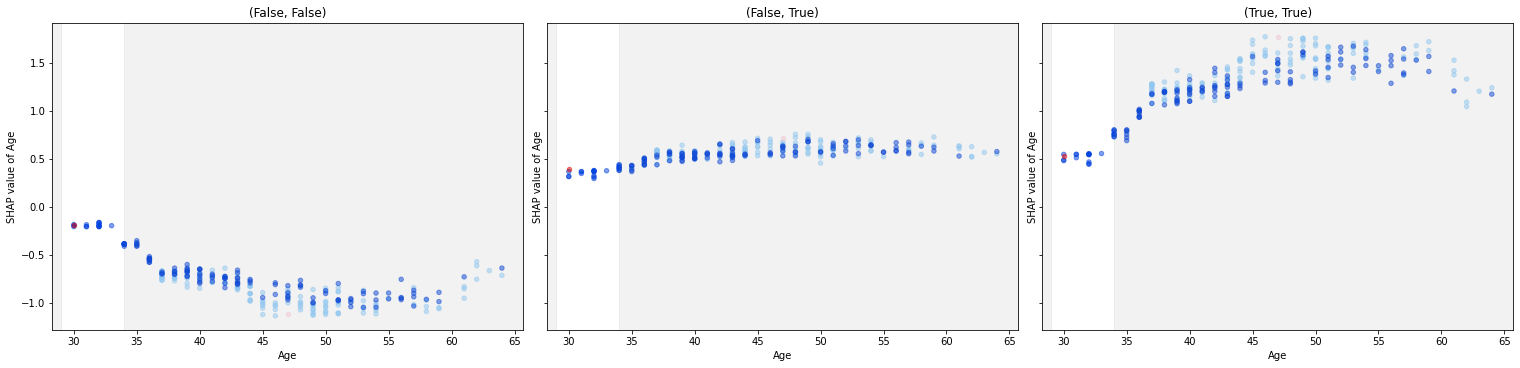

Hours per week == 48.0
Hours per week <= 47.0 --> {'(False, False)': 1}
Hours per week >= 49.0 --> {'(True, True)': 1}


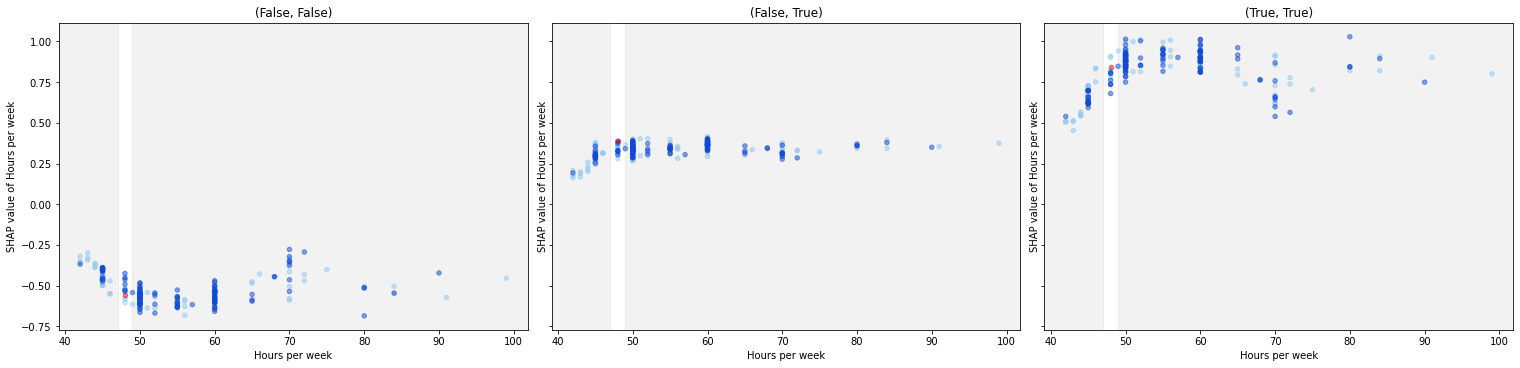

In [23]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

### Node RLRLRRRRRRRR

In [24]:
node = node.parent.parent.get_right()
node, node.class_counts, node.distance

(RLRLRRRRRRRR,
 (False, False)    377
 (True, True)       83
 (False, True)       1
 dtype: int64,
 7.591490435613699)

Relationship == 4.0
Relationship <= 3.0 --> {'(False, False)': 1}


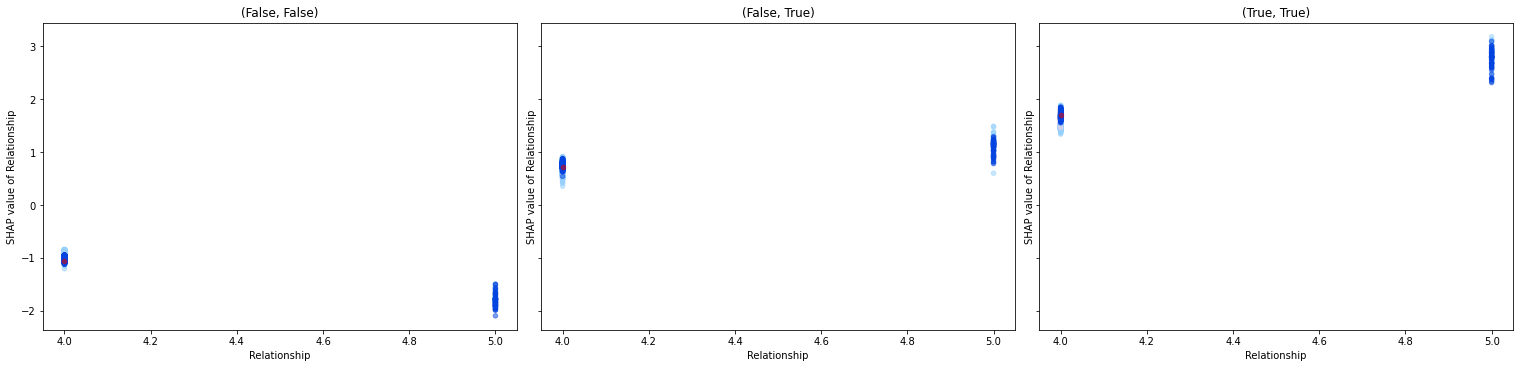

Age == 56.0
Age <= 44.0 --> {'(False, False)': 1}
Age >= 60.0 --> {'(False, False)': 1}


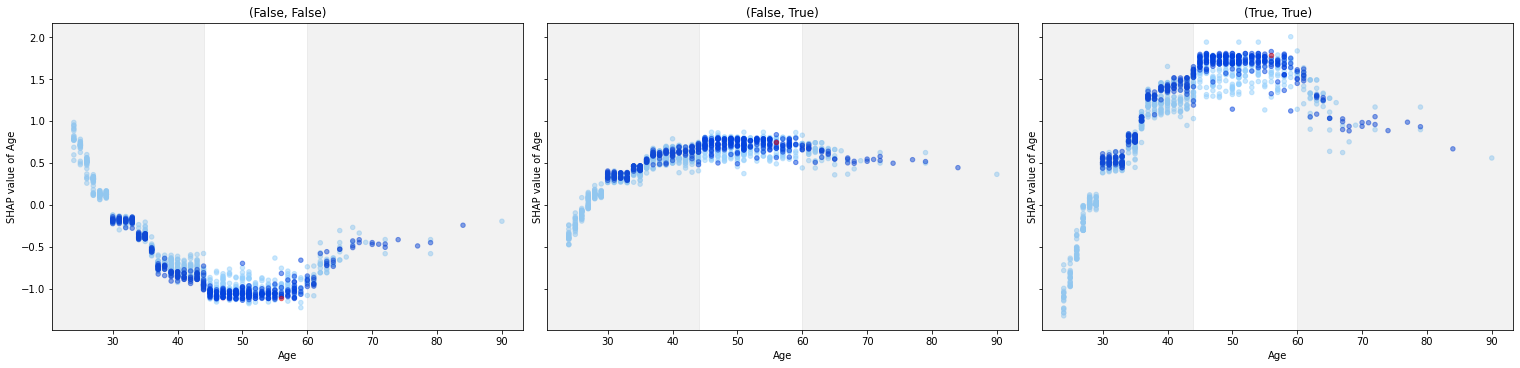

Occupation == 3.0
Occupation <= 0.0 --> {'(False, False)': 1}
Occupation >= 4.0 --> {'(True, True)': 1}


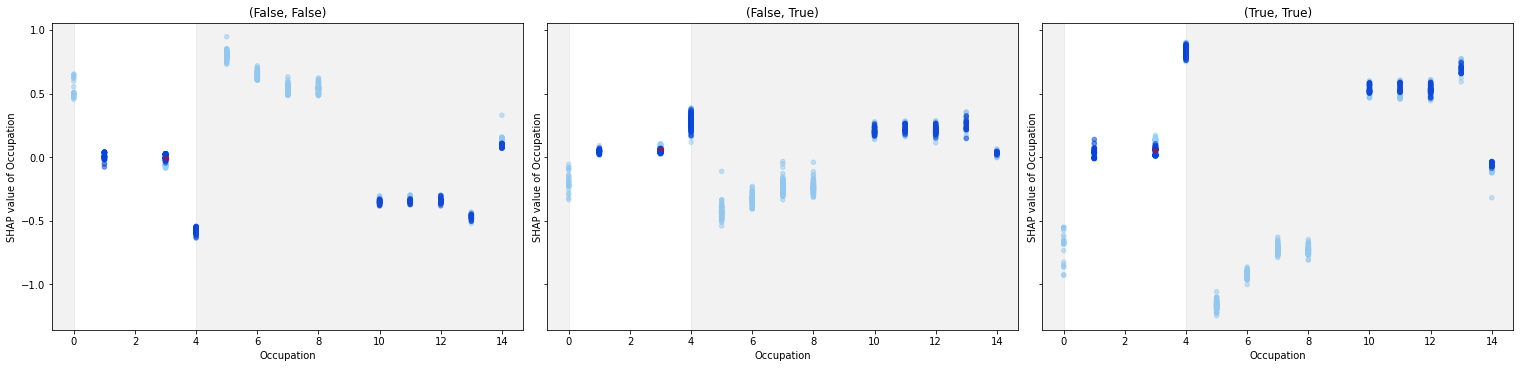

In [25]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.parent.parent.plot_feature(feature, focus=node, alpha=0.5)